# MACCS Training Model

In [1]:
import pandas as pd
import random
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
import selfies as sf
import group_selfies as gsf
from rdkit import Chem
import shap

random.seed(42)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:

import optuna
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    make_scorer,
    roc_curve,
    auc,
    hamming_loss,
    jaccard_score,
)
import matplotlib.pyplot as plt


# Data Processing

In [3]:
chembl_df = pd.read_csv("../../data/ExperimentData/pChEMBL_data.csv")
maccs_df = pd.read_csv("../../data/ExperimentData/pChEMBL_MACCS_fingerprints.csv")
print(chembl_df.head(), chembl_df.shape)
print(maccs_df.head(), maccs_df.shape)

  Molecule ChEMBL ID                                       Smiles  \
0      CHEMBL1643678   Fc1ccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)cc1   
1      CHEMBL1643853  COc1cccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)c1   
2      CHEMBL1643672             c1cc2nc3c(c(N4CCCCC4)n2n1)CCNCC3   
3      CHEMBL2022190          Cl.NC[C@H]1C[C@@H]1c1ccccc1OCC1CCC1   
4      CHEMBL2022193           Cl.NC[C@@H]1C[C@H]1c1ccccc1OCC1CC1   

   pChEMBL Value     Comment  
0           8.52         NaN  
1           7.40         NaN  
2           6.23         NaN  
3            NaN  Not Active  
4            NaN  Not Active   (1281, 4)
  Molecule ChEMBL ID  0  1  2  3  4  5  6  7  8  ...  157  158  159  160  161  \
0      CHEMBL1643678  0  0  0  0  0  0  0  0  1  ...    1    1    0    0    1   
1      CHEMBL1643853  0  0  0  0  0  0  0  0  1  ...    1    1    1    1    1   
2      CHEMBL1643672  0  0  0  0  0  0  0  0  0  ...    0    1    0    0    1   
3      CHEMBL2022190  0  0  0  0  0  0  0  0  0  ...    1    1   

## Remove duplicates

In [4]:
# check if there are duplicated values in the dataframes
print(chembl_df["Molecule ChEMBL ID"].duplicated().sum())
print(maccs_df["Molecule ChEMBL ID"].duplicated().sum())
print(chembl_df.shape, maccs_df.shape)

# remove duplicates
chembl_df_unique = chembl_df.drop_duplicates(subset="Molecule ChEMBL ID")
maccs_df_unique = maccs_df.drop_duplicates(subset="Molecule ChEMBL ID")

# merge features and targets
merge_data = pd.merge(chembl_df_unique, maccs_df_unique, on="Molecule ChEMBL ID", how="left")
print(merge_data.head(), merge_data.shape)


421
421
(1281, 4) (1281, 168)
  Molecule ChEMBL ID                                       Smiles  \
0      CHEMBL1643678   Fc1ccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)cc1   
1      CHEMBL1643853  COc1cccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C2)c1   
2      CHEMBL1643672             c1cc2nc3c(c(N4CCCCC4)n2n1)CCNCC3   
3      CHEMBL2022190          Cl.NC[C@H]1C[C@@H]1c1ccccc1OCC1CCC1   
4      CHEMBL2022193           Cl.NC[C@@H]1C[C@H]1c1ccccc1OCC1CC1   

   pChEMBL Value     Comment  0  1  2  3  4  5  ...  157  158  159  160  161  \
0           8.52         NaN  0  0  0  0  0  0  ...    1    1    0    0    1   
1           7.40         NaN  0  0  0  0  0  0  ...    1    1    1    1    1   
2           6.23         NaN  0  0  0  0  0  0  ...    0    1    0    0    1   
3            NaN  Not Active  0  0  0  0  0  0  ...    1    1    0    0    1   
4            NaN  Not Active  0  0  0  0  0  0  ...    1    1    0    0    1   

   162  163  164  165  166  
0    1    1    1    1    0  
1    1    1    1

## process the target data -> split to psy and non-psy

In [5]:
filtered_df = merge_data[merge_data["Comment"] != "Not Determined"]
filtered_df.fillna(0, inplace=True)
print(filtered_df.shape)

# check psy ad non-psy number
psy_chembl = filtered_df[filtered_df["pChEMBL Value"] == 0].drop(["Comment"], axis=1)
non_psy_chembl = filtered_df[filtered_df["pChEMBL Value"] != 0].drop(["Comment"], axis=1)

print(psy_chembl.shape)
print(non_psy_chembl.shape)

combine_psy_nonpsy = filtered_df.drop(['Comment'], axis = 1).iloc[:, 2:]
print(combine_psy_nonpsy.head())    

(840, 171)
(277, 170)
(563, 170)
   pChEMBL Value  0  1  2  3  4  5  6  7  8  ...  157  158  159  160  161  \
0           8.52  0  0  0  0  0  0  0  0  1  ...    1    1    0    0    1   
1           7.40  0  0  0  0  0  0  0  0  1  ...    1    1    1    1    1   
2           6.23  0  0  0  0  0  0  0  0  0  ...    0    1    0    0    1   
3           0.00  0  0  0  0  0  0  0  0  0  ...    1    1    0    0    1   
4           0.00  0  0  0  0  0  0  0  0  0  ...    1    1    0    0    1   

   162  163  164  165  166  
0    1    1    1    1    0  
1    1    1    1    1    0  
2    1    1    0    1    0  
3    1    1    1    1    1  
4    1    1    1    1    1  

[5 rows x 168 columns]



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Training

In [6]:
X = combine_psy_nonpsy.iloc[:, 2:]
y_label = (combine_psy_nonpsy.iloc[:, 0] > 0).astype(int)
y_value = combine_psy_nonpsy["pChEMBL Value"]


print(X.shape, y_label.shape, y_value.shape)
print(X.head())
print(y_label.head())


(840, 166) (840,) (840,)
   1  2  3  4  5  6  7  8  9  10  ...  157  158  159  160  161  162  163  164  \
0  0  0  0  0  0  0  0  1  0   0  ...    1    1    0    0    1    1    1    1   
1  0  0  0  0  0  0  0  1  0   0  ...    1    1    1    1    1    1    1    1   
2  0  0  0  0  0  0  0  0  0   0  ...    0    1    0    0    1    1    1    0   
3  0  0  0  0  0  0  0  0  0   0  ...    1    1    0    0    1    1    1    1   
4  0  0  0  0  0  0  0  0  0   0  ...    1    1    0    0    1    1    1    1   

   165  166  
0    1    0  
1    1    0  
2    1    0  
3    1    1  
4    1    1  

[5 rows x 166 columns]
0    1
1    1
2    1
3    0
4    0
Name: pChEMBL Value, dtype: int64


### Single Label

In [7]:
# Nested cross-validation setup
outer_ncv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_ncv = StratifiedKFold(n_splits=5, shuffle=True, random_state=43)


# Define the objective function for the Inner loop
def objective(trial, X_train_inner, y_train_inner):
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 10, 100)
    max_depth = trial.suggest_int("max_depth", 5, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # Create a random forest classifier
    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42,
    )

    # Cross-validation for hyperparameter tuning
    scoring = make_scorer(accuracy_score, greater_is_better=True)
    cv_scores = cross_val_score(
        rf_classifier, X_train_inner, y_train_inner, cv=inner_ncv, scoring=scoring
    )
    return cv_scores.mean()


[I 2025-01-19 11:23:34,337] A new study created in memory with name: no-name-b897faa7-58d7-472d-86f9-5b95484e0343


[I 2025-01-19 11:23:34,658] Trial 0 finished with value: 0.7633499170812604 and parameters: {'n_estimators': 35, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 0 with value: 0.7633499170812604.
[I 2025-01-19 11:23:34,824] Trial 1 finished with value: 0.7767385295743504 and parameters: {'n_estimators': 37, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 1 with value: 0.7767385295743504.
[I 2025-01-19 11:23:35,060] Trial 2 finished with value: 0.7960641238253178 and parameters: {'n_estimators': 45, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 2 with value: 0.7960641238253178.
[I 2025-01-19 11:23:35,382] Trial 3 finished with value: 0.7647982310668878 and parameters: {'n_estimators': 78, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 2 with value: 0.7960641238253178.
[I 2025-01-19 11:23:3

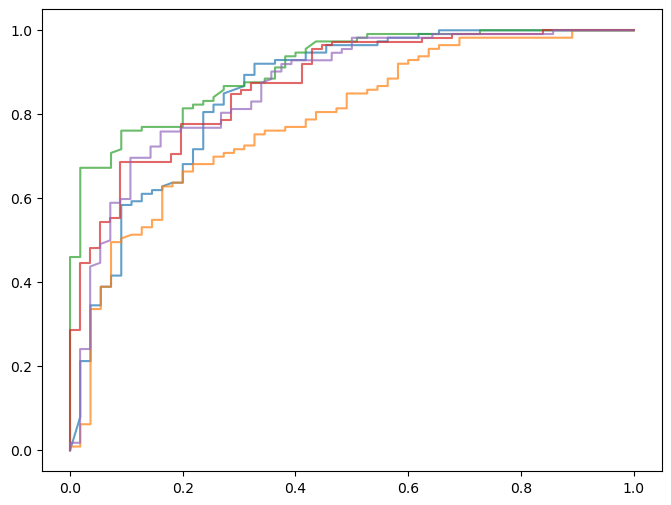

In [8]:
# Outer loop: Statistical evaluation
outer_scores = []
# ncv_label_scores = {label: [] for label in y.columns}

# For ROC plotting
mean_fpr = np.linspace(0, 1, 100)  # Average FPR for interpolation
tprs = []  # TPRs for all folds
aucs = []  # AUC scores for all folds

all_feature_importances = []
shap_values_list = []
shap_summary_data = []  # Store SHAP values for global summary plot

plt.figure(figsize=(8, 6))  # Initialize the plot

for fold, (train_index, test_index) in enumerate(outer_ncv.split(X, y_label), start=1):
    # Split data into training and testing sets for the outer fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_label.iloc[train_index], y_label.iloc[test_index]

    # Skip fold if only one class is present
    if len(np.unique(y_test)) < 2:
        print(
            f"Fold {fold}: Only one class present in y_test. Skipping ROC computation."
        )
        continue

    # Inner loop: Hyperparameter search
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)

    # Train the model using the best hyperparameters
    best_params = study.best_params
    best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
    best_rf_classifier.fit(X_train, y_train)

    # Store feature importances
    feature_importances = best_rf_classifier.feature_importances_
    all_feature_importances.append(feature_importances)

    # SHAP analysis
    explainer = shap.TreeExplainer(best_rf_classifier)
    shap_values = explainer.shap_values(X_test)
    shap_values_list.append(shap_values)

    # Aggregate SHAP values for summary (global analysis)
    shap_summary_data.append((shap_values, X_test))

    # Predict on the test set
    y_test_pred = best_rf_classifier.predict(X_test)
    y_test_pred_proba = best_rf_classifier.predict_proba(X_test)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Plot ROC curve for the current fold
    plt.plot(fpr, tpr, label=f"Fold {fold} (AUC = {roc_auc:.2f})", alpha=0.7)

    # Interpolate TPR for consistent plotting
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

    # Evaluate the model on the outer fold's test set
    outer_scores.append(
        {
            "accuracy": accuracy_score(y_test, y_test_pred),
            "f1_score": f1_score(y_test, y_test_pred, average="weighted"),
        }
    )


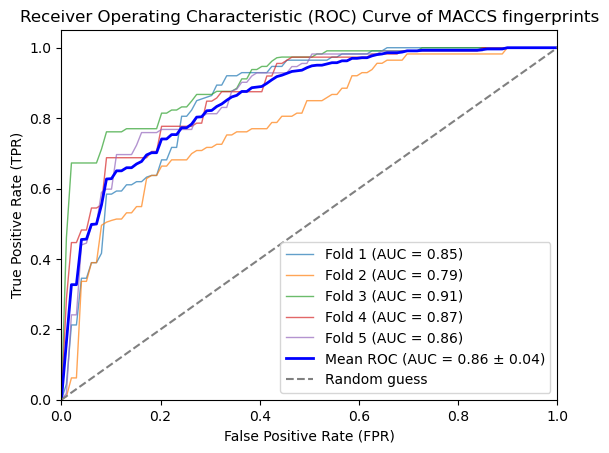

Accuracy: Mean = 0.80, Std = 0.03
F1_score: Mean = 0.79, Std = 0.04
Fold 1:
  accuracy: 0.8274
  f1_score: 0.8218
Fold 2:
  accuracy: 0.7321
  f1_score: 0.7235
Fold 3:
  accuracy: 0.8095
  f1_score: 0.8076
Fold 4:
  accuracy: 0.8036
  f1_score: 0.8011
Fold 5:
  accuracy: 0.8155
  f1_score: 0.8084


In [13]:
# Compute and plot ROC curve for each fold
# plt.figure(figsize=(10, 8))

for fold, tpr in enumerate(tprs, start=1):
    # Plot each fold's ROC curve
    plt.plot(
        mean_fpr,
        tpr,
        lw=1,
        alpha=0.7,
        label=f"Fold {fold} (AUC = {aucs[fold-1]:.2f})",
    )

# Compute and plot mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  # Ensure the curve ends at (1, 1)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot the mean ROC curve
plt.plot(
    mean_fpr,
    mean_tpr,
    color="blue",
    lw=2,
    label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
)

# Add reference line and format the plot
plt.plot([0, 1], [0, 1], color="grey", linestyle="--", label="Random guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve of MACCS fingerprints")
plt.legend(loc="lower right")
plt.show()

# Calculate mean and standard deviation for overall metrics
metrics_summary = {
    key: [score[key] for score in outer_scores] for key in outer_scores[0]
}
for metric, values in metrics_summary.items():
    print(
        f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
    )

# Print final scores
for i, scores in enumerate(outer_scores):
    print(f"Fold {i+1}:")
    for metric, value in scores.items():
        print(f"  {metric}: {value:.4f}")


In [10]:
print(best_params)
print(outer_scores)

{'n_estimators': 29, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False}
[{'accuracy': 0.8273809523809523, 'f1_score': 0.8217969325564263}, {'accuracy': 0.7321428571428571, 'f1_score': 0.7234779987944545}, {'accuracy': 0.8095238095238095, 'f1_score': 0.8075862338372592}, {'accuracy': 0.8035714285714286, 'f1_score': 0.8011263926866098}, {'accuracy': 0.8154761904761905, 'f1_score': 0.8084217704470869}]


### Feature importance

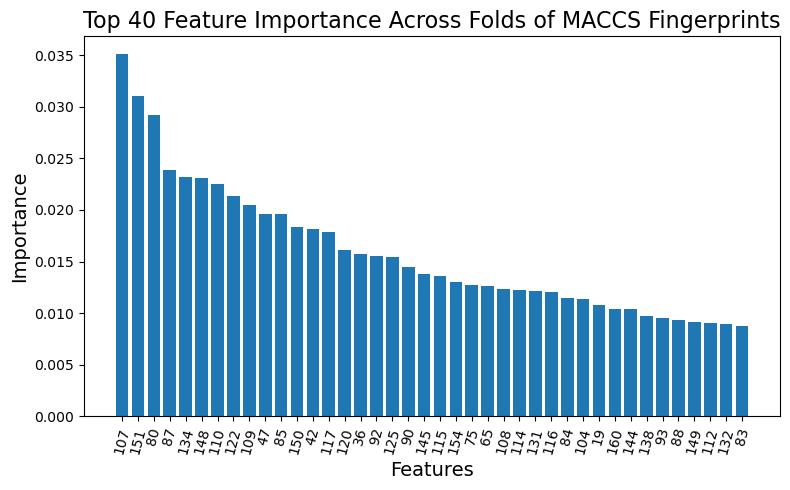

Top 40 Feature Importances (averaged across folds):
107: 0.0351
151: 0.0310
80: 0.0292
87: 0.0239
134: 0.0232
148: 0.0231
110: 0.0225
122: 0.0213
109: 0.0204
47: 0.0196
85: 0.0196
150: 0.0183
42: 0.0181
117: 0.0179
120: 0.0161
36: 0.0157
92: 0.0155
125: 0.0155
90: 0.0145
145: 0.0138
115: 0.0136
154: 0.0130
75: 0.0127
65: 0.0127
108: 0.0123
114: 0.0122
131: 0.0122
116: 0.0121
84: 0.0114
104: 0.0113
19: 0.0108
160: 0.0104
144: 0.0104
138: 0.0098
93: 0.0096
88: 0.0093
149: 0.0091
112: 0.0091
132: 0.0089
83: 0.0088


In [15]:
# Compute and visualize averaged feature importance
avg_feature_importances = np.mean(all_feature_importances, axis=0)
sorted_indices = np.argsort(avg_feature_importances)[::-1]
sorted_features = X.columns[sorted_indices]

N = 40  # Number of features to plot

# Select top N features
top_indices = sorted_indices[:N]
top_features = sorted_features[:N]
top_importances = avg_feature_importances[top_indices]


# Plot top N feature importance
plt.figure(figsize=(8, 5))
plt.bar(range(N), top_importances, align="center")
plt.xticks(range(N), top_features, rotation=75)
plt.title(f"Top {N} Feature Importance Across Folds of MACCS Fingerprints", fontsize=16)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Importance", fontsize=14)
plt.tight_layout()
plt.show()

# Output the sorted feature importance for top N features
print(f"Top {N} Feature Importances (averaged across folds):")
for feature, importance in zip(top_features, top_importances):
    print(f"{feature}: {importance:.4f}")


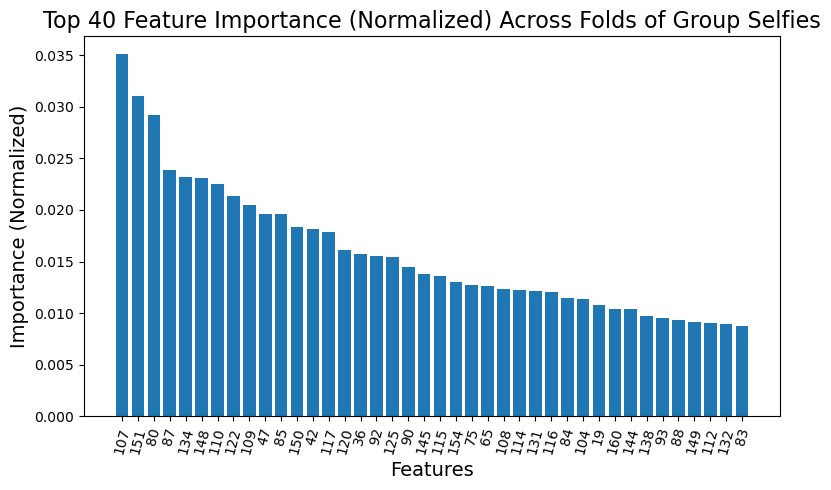

Top 40 Feature Importances (normalized, averaged across folds) of Group Selfies:
107: 0.0351
151: 0.0310
80: 0.0292
87: 0.0239
134: 0.0232
148: 0.0231
110: 0.0225
122: 0.0213
109: 0.0204
47: 0.0196
85: 0.0196
150: 0.0183
42: 0.0181
117: 0.0179
120: 0.0161
36: 0.0157
92: 0.0155
125: 0.0155
90: 0.0145
145: 0.0138
115: 0.0136
154: 0.0130
75: 0.0127
65: 0.0127
108: 0.0123
114: 0.0122
131: 0.0122
116: 0.0121
84: 0.0114
104: 0.0113
19: 0.0108
160: 0.0104
144: 0.0104
138: 0.0098
93: 0.0096
88: 0.0093
149: 0.0091
112: 0.0091
132: 0.0089
83: 0.0088


In [16]:
# Compute and normalize averaged feature importance
avg_feature_importances = np.mean(all_feature_importances, axis=0)
normalized_importances = avg_feature_importances / np.sum(avg_feature_importances)

# Sort and select top N features
sorted_indices = np.argsort(normalized_importances)[::-1]
sorted_features = X.columns[sorted_indices]
top_indices = sorted_indices[:N]
top_features = sorted_features[:N]
top_importances = normalized_importances[top_indices]

# Plot top N feature importance
plt.figure(figsize=(8, 5))
plt.bar(range(N), top_importances, align="center")
plt.xticks(range(N), top_features, rotation=75, fontsize=10)
plt.title(
    f"Top {N} Feature Importance (Normalized) Across Folds of Group Selfies",
    fontsize=16,
)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Importance (Normalized)", fontsize=14)
plt.tight_layout()
plt.show()

# Output the sorted feature importance for top N features
print(
    f"Top {N} Feature Importances (normalized, averaged across folds) of Group Selfies:"
)
for feature, importance in zip(top_features, top_importances):
    print(f"{feature}: {importance:.4f}")


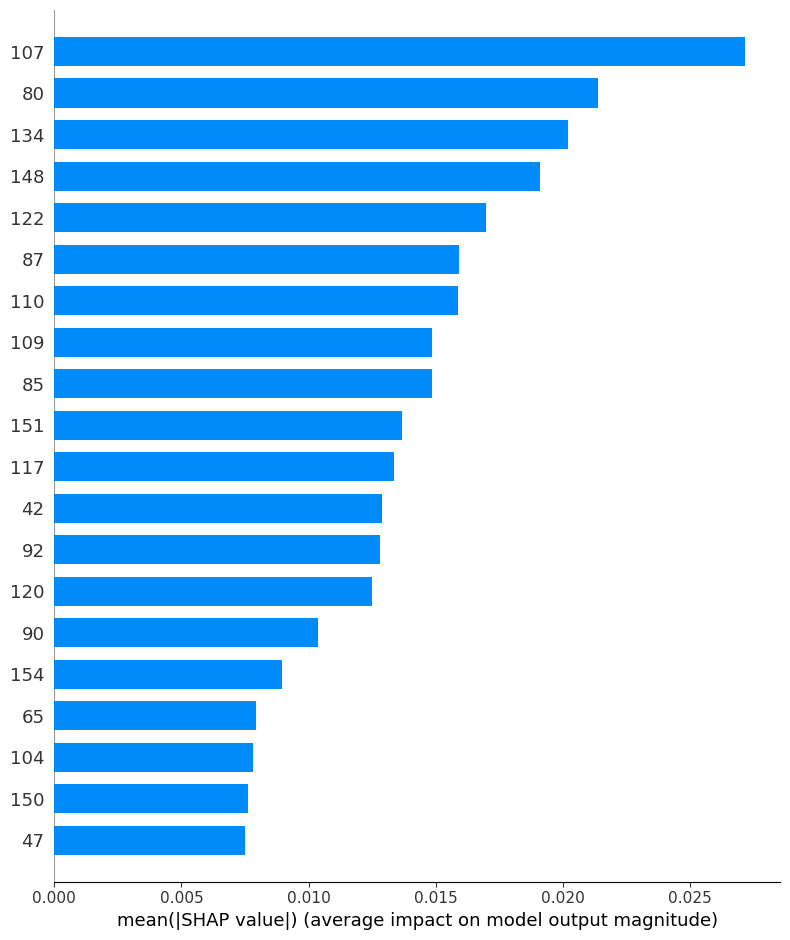

SHAP values shape: (1680, 166)
Feature matrix shape: (840, 166)


In [12]:
# Plot global SHAP summary after all folds
all_shap_values = [sv for shap_values, _ in shap_summary_data for sv in shap_values]
all_shap_features = pd.concat([X for _, X in shap_summary_data])

shap.summary_plot(
    np.vstack(all_shap_values), all_shap_features, plot_type="bar", show=True
)

# shap.summary_plot(
#     np.vstack(all_shap_values),
#     all_shap_features,
#     plot_type="dot",
#     show=True,
# )
print("SHAP values shape:", np.vstack(all_shap_values).shape)
print("Feature matrix shape:", all_shap_features.shape)
